<a href="https://colab.research.google.com/github/arifpras/ExpectedDemand/blob/main/20240226_podem01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">

  <h1> Predicting Demand in the Primary Market: Pycaret</h1>
</div>

<div class="markdown-google-sans">

## <strong> Data Preparation </strong>
</div>

## Libraries

In [1]:
%%capture

# !pip install -U scikit-learn==0.24.2
# !pip install -U imbalanced-learn

# %pip install openpyxl
# %pip install shap
# %pip install pycaret

!pip show pycaret || pip install pycaret

In [2]:
# Subsequent cells can use the installed library
import pycaret
pycaret.__version__

'3.3.0'

In [3]:
from pycaret.regression import *

import numpy as np
import pandas as pd
import openpyxl as xl
import matplotlib.pyplot as plt
import seaborn as sns

## Database

### Load

In [8]:
df_train00 = pd.read_excel('/content/drive/MyDrive/00database/db_monthfrac.xlsx', sheet_name='database')
df_train00['incoming_bid'] = df_train00['incoming_bid'].astype(float)
df_train00['issuance_date'] = pd.to_datetime(df_train00['issuance_date'], format='%Y-%m-%d')

df_train00.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1917 entries, 0 to 1916
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   issued_series     1917 non-null   object        
 1   issuance_date     1917 non-null   datetime64[ns]
 2   issuance_year     1917 non-null   int64         
 3   issuance_week     1917 non-null   int64         
 4   monthfrac         1917 non-null   int64         
 5   eid_weeks         1917 non-null   int64         
 6   srbi_issuance     1917 non-null   int64         
 7   vix_indicator     1917 non-null   int64         
 8   bi_covid          1917 non-null   int64         
 9   gso_issuance      1917 non-null   int64         
 10  investment_grade  1917 non-null   int64         
 11  incoming_bid      1917 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(9), object(1)
memory usage: 179.8+ KB


In [11]:
df_train00['issued_series'].value_counts()

sun10    295
sun20    290
spn12    275
sun15    275
sun05    269
spn03    241
sun30    173
spn09     76
sun07     11
sun08      9
sun04      1
vr04       1
sun02      1
Name: issued_series, dtype: int64

In [17]:
df_train00.describe()

,issuance_year,issuance_week,monthfrac,eid_weeks,srbi_issuance,vix_indicator,bi_covid,gso_issuance,investment_grade,incoming_bid
count,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1.917000e+03
mean,2017.217527,24.440271,124.326552,0.082942,0.033385,0.081377,0.246218,0.022431,0.861763,6.281199e+06
std,4.311361,14.120611,108.423452,0.275867,0.179688,0.273485,0.430919,0.148119,0.345238,5.928876e+06
min,2009.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,2014.000000,12.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.381000e+06
50%,2018.000000,24.000000,119.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.415000e+06
75%,2021.000000,37.000000,188.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,8.000000e+06
max,2024.000000,51.000000,367.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.516780e+07


<Axes: xlabel='incoming_bid', ylabel='issuance_week'>

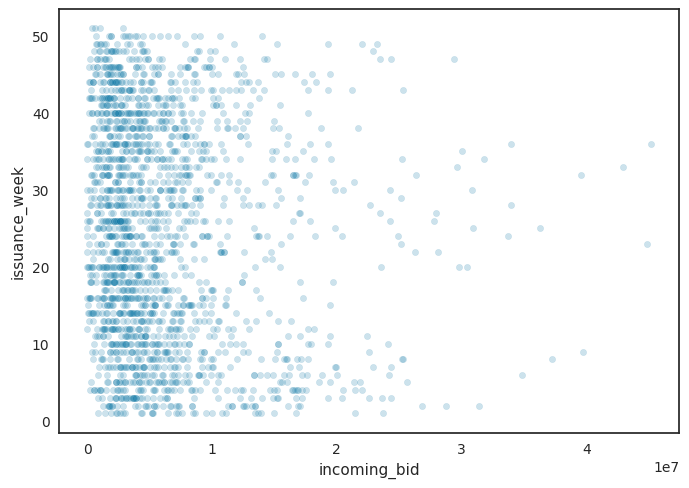

In [13]:
df_train00.plot(kind = 'scatter', x = 'incoming_bid', y = 'issuance_week', alpha = 0.2)

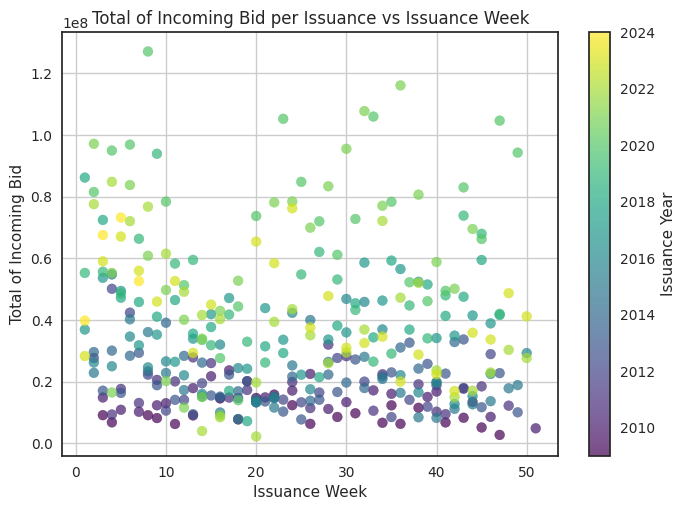

In [14]:
# import matplotlib.pyplot as plt

grouped_series01 = df_train00.groupby(['issuance_date']).agg({
    'incoming_bid': 'sum',
    'issuance_week': 'mean',
    'issuance_year': 'mean'
}).reset_index()

# Convert 'issuance_year' to integer
grouped_series01['issuance_year'] = grouped_series01['issuance_year'].astype(int)


# Scatter plot
# plt.figure(figsize=(10, 6))
plt.scatter(grouped_series01['issuance_week'], grouped_series01['incoming_bid'], s=50, c=grouped_series01['issuance_year'], alpha=0.7, cmap='viridis')
plt.title('Total of Incoming Bid per Issuance vs Issuance Week')
plt.xlabel('Issuance Week')
plt.ylabel('Total of Incoming Bid')
plt.colorbar(label='Issuance Year')
plt.grid(True)
plt.show()

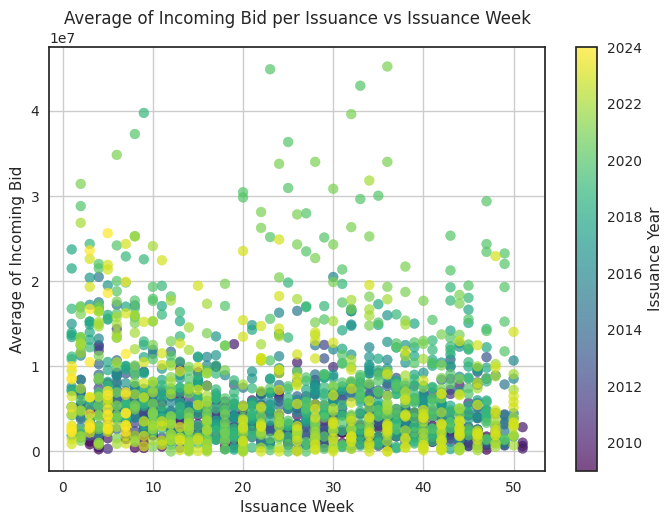

In [18]:
# import matplotlib.pyplot as plt

grouped_series02 = df_train00.groupby(['issuance_date', 'issued_series']).agg({
    'incoming_bid': 'mean', #average
    'issuance_week': 'mean',
    'issuance_year': 'mean'
}).reset_index()

# Convert 'issuance_year' to integer
grouped_series02['issuance_year'] = grouped_series02['issuance_year'].astype(int)


# Scatter plot
# plt.figure(figsize=(10, 6))
plt.scatter(grouped_series02['issuance_week'], grouped_series02['incoming_bid'], s=50, c=grouped_series02['issuance_year'], alpha=0.7, cmap='viridis')
plt.title('Average of Incoming Bid per Issuance vs Issuance Week')
plt.xlabel('Issuance Week')
plt.ylabel('Average of Incoming Bid')
plt.colorbar(label='Issuance Year')
plt.grid(True)
plt.show()

In [19]:
# sns.catplot(x='issued_series', y='incoming_bid', data=grouped_series02,
#                 kind='boxen', col='issuance_year', col_wrap=2)

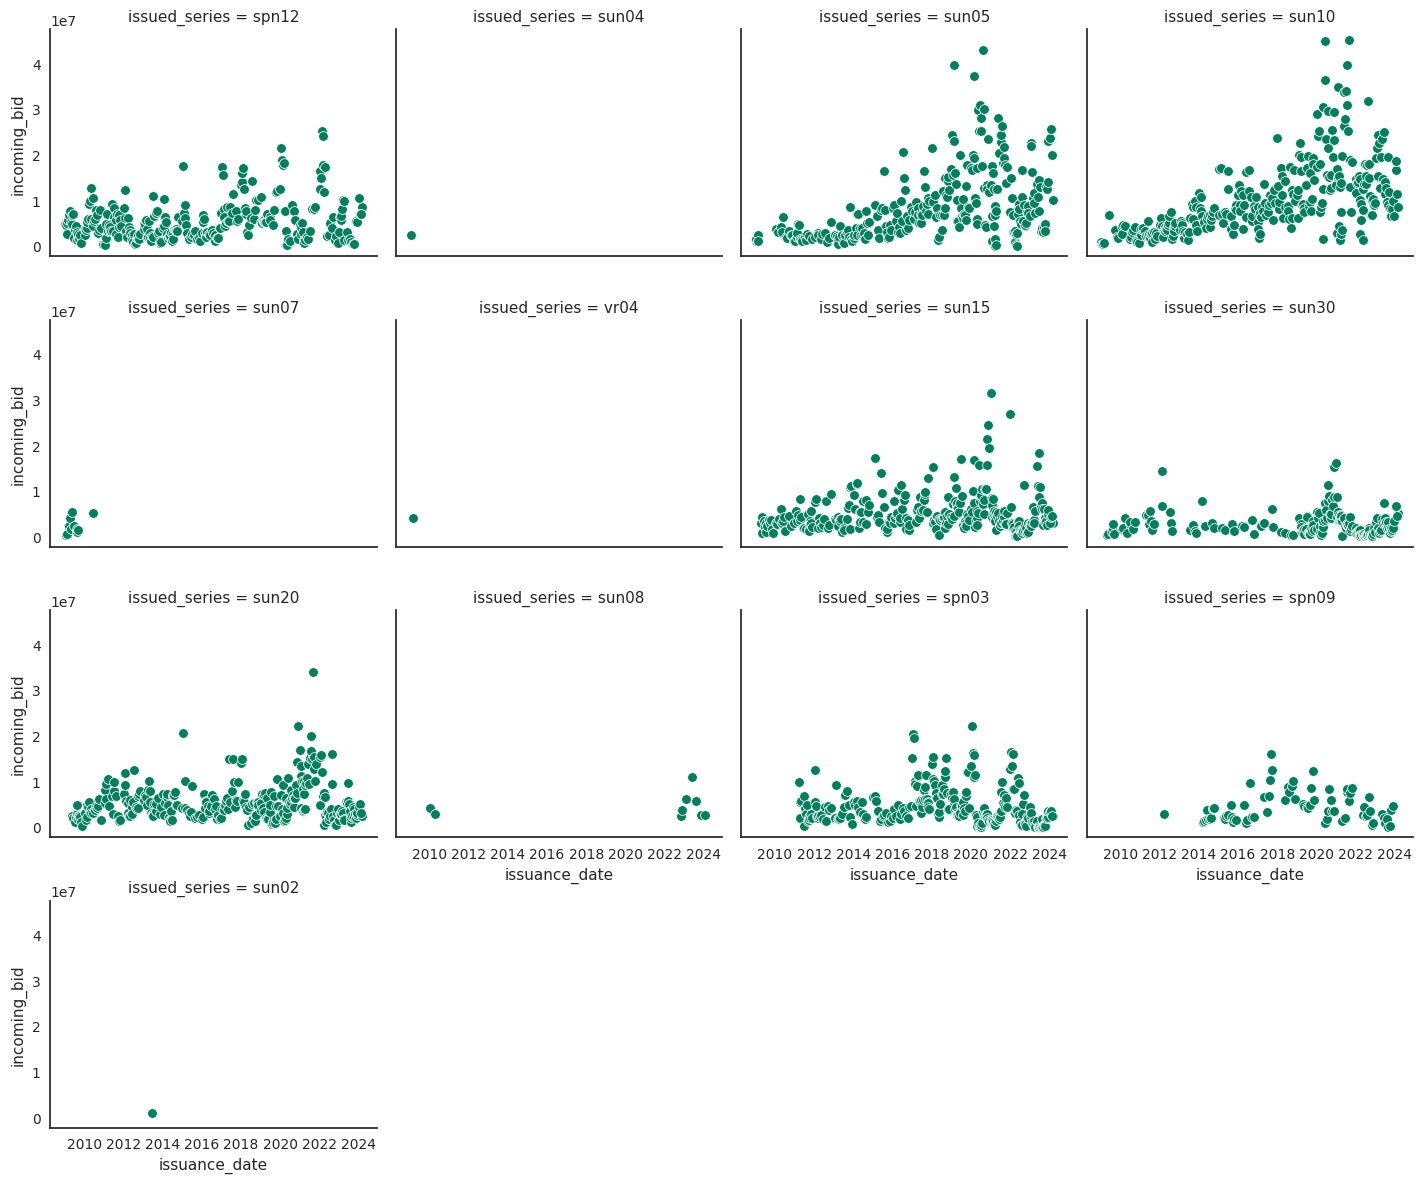

In [20]:
# import seaborn as sns
# import matplotlib.pyplot as plt

sns.set_style("white")

# Create a FacetGrid and use map to create subplots based on 'FacetVar'
ch01 = sns.FacetGrid(df_train00, col='issued_series', col_wrap=4, height=3, aspect=1.2)
ch01.map(sns.scatterplot, 'issuance_date', 'incoming_bid', color='#007e5d')

# Show the plot
# plt.show()


In [21]:
corr_matrix = df_train00.corr()
corr_matrix['incoming_bid'].sort_values(ascending=False)

incoming_bid        1.000000
issuance_year       0.249346
investment_grade    0.193016
bi_covid            0.174754
eid_weeks          -0.011549
srbi_issuance      -0.032817
vix_indicator      -0.049531
issuance_week      -0.098527
gso_issuance       -0.100473
monthfrac          -0.103115
Name: incoming_bid, dtype: float64

In [22]:
df_train01 = df_train00[~df_train00['issued_series'].isin(['sun04', 'sun02', 'vr04', 'spn09', 'sun07'])]

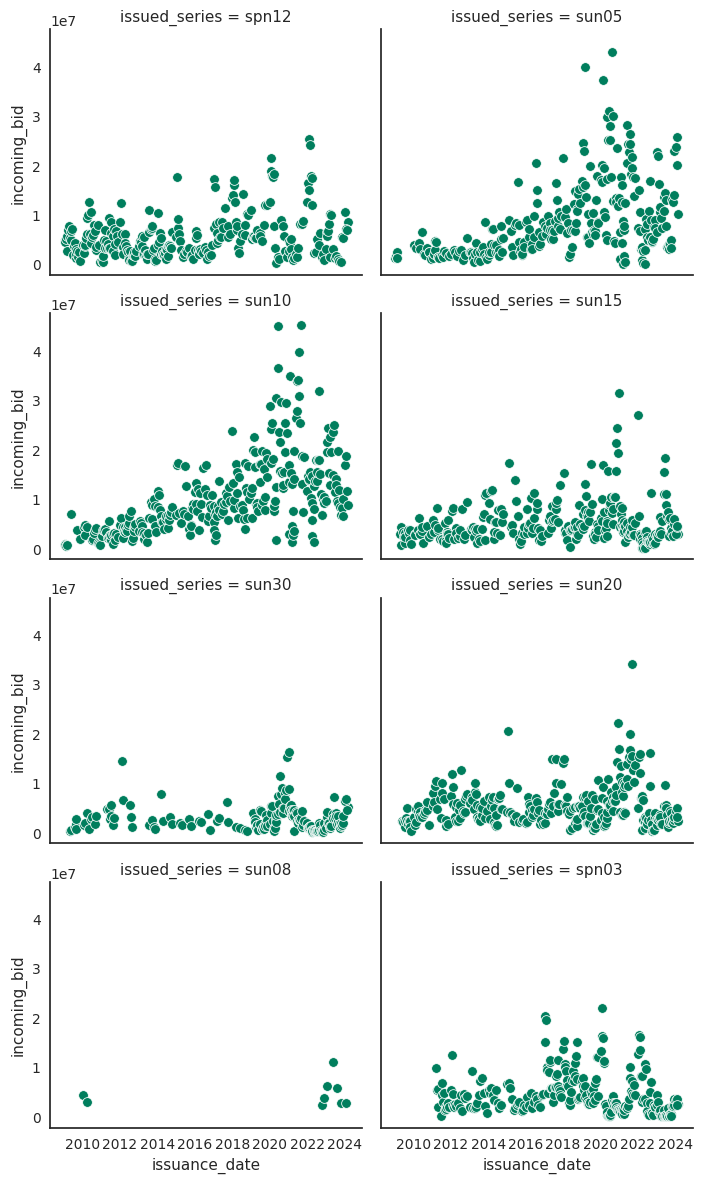

In [23]:
# import seaborn as sns
# import matplotlib.pyplot as plt

sns.set_style("white")

# Create a FacetGrid and use map to create subplots based on 'FacetVar'
ch02 = sns.FacetGrid(df_train01, col='issued_series', col_wrap=2, height=3, aspect=1.2)
ch02.map(sns.scatterplot, 'issuance_date', 'incoming_bid', color='#007e5d')

# Show the plot
# plt.show()


In [24]:
# Get the order of categories
issd_series = df_train01['issued_series'].unique()

# Sort the order
issd_series.sort()

# Create a boxplot with sorted order
# sns.boxplot(x='issued_series', y='incoming_bid', data=df_train01,
#             order=issd_series, hue='issuance_year')

# sns.boxplot(x='issued_series', y='incoming_bid', data=df_train01,
#             order=issd_series)
# plt.show()

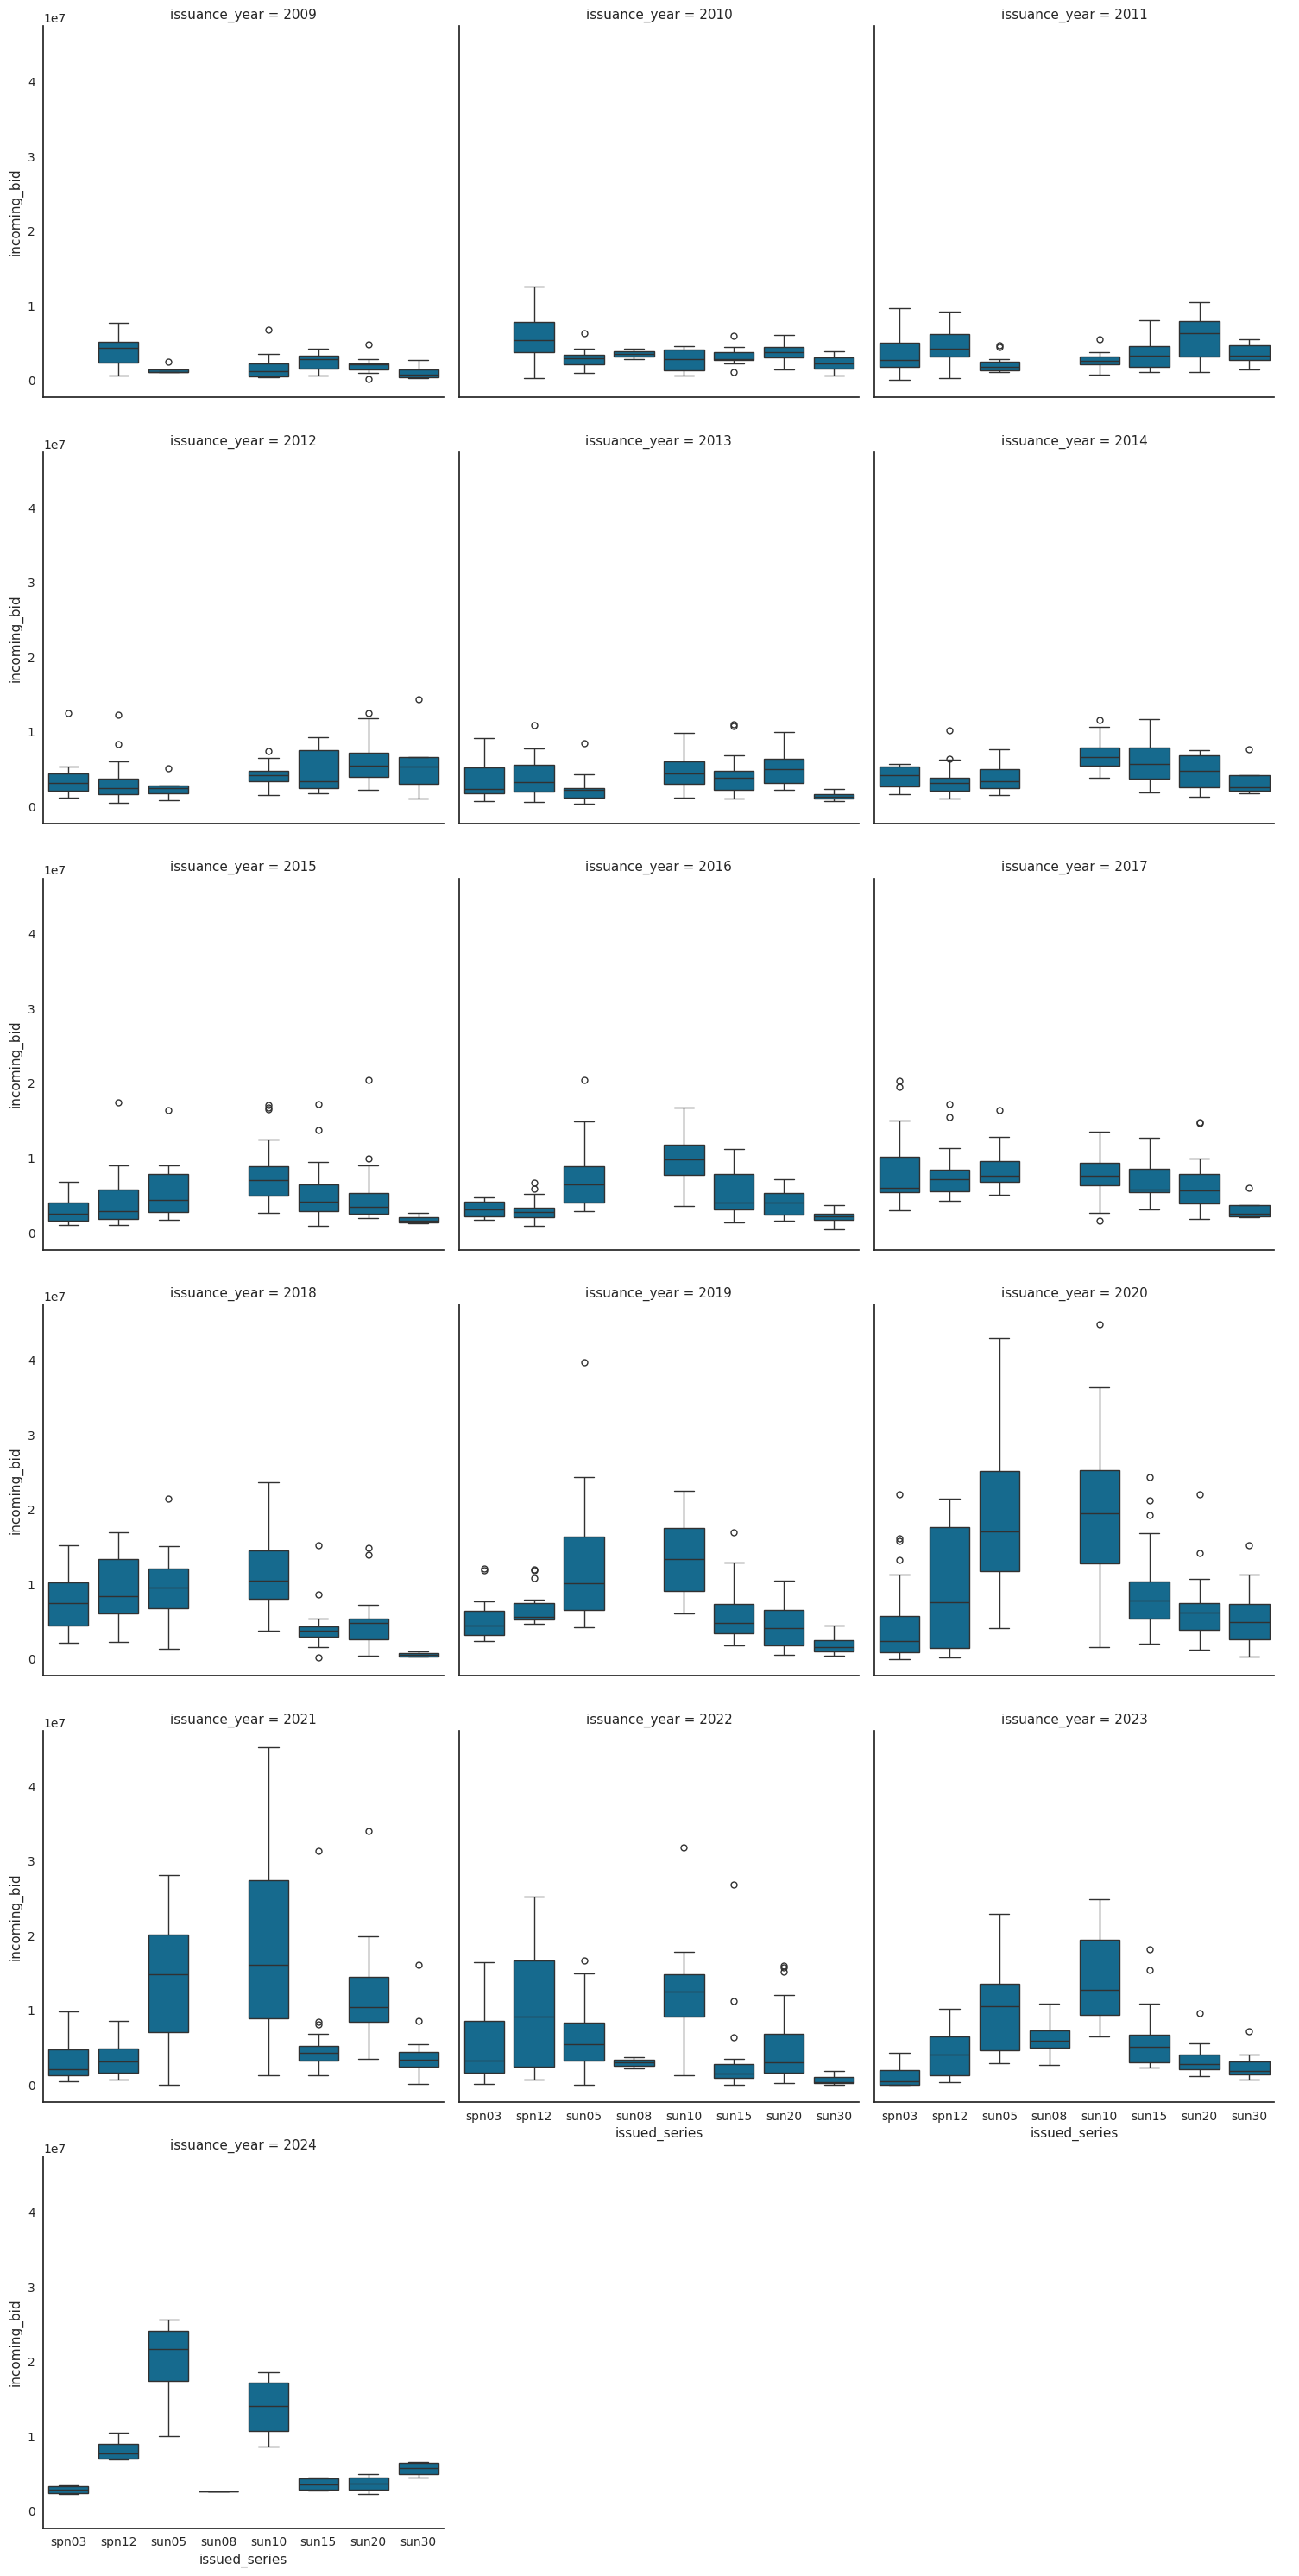

In [25]:
sns.catplot(x='issued_series', y='incoming_bid', data=df_train01,
                order=issd_series, kind='box', col='issuance_year', col_wrap=3)

### Split: Biased

In [26]:
# df_train02 = df_train01.sample(frac=0.9, random_state=786)
# df_unseen01 = df_train01.drop(df_train02.index)

# df_train02.reset_index(drop=True, inplace=True)
# df_unseen01.reset_index(drop=True, inplace=True)

# print('Data for Modeling: ' + str(df_train02.shape))
# print('Unseen Data For Predictions: ' + str(df_unseen01.shape))

In [27]:
# print("Train: \n{} \n\nTest: \n{}".format(df_train02['issued_series'].value_counts(), df_unseen01['issued_series'].value_counts()))

### Split: Stratified

In [28]:
from sklearn.model_selection import StratifiedShuffleSplit

# Assuming df is your DataFrame and 'target_column' is the target variable
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, test_index in split.split(df_train01, df_train01['issued_series']):
    # Explicitly reset the index
    df_train02 = df_train01.iloc[train_index]
    df_unseen01 = df_train01.iloc[test_index]

# Explicitly reset the index for df_train02 and df_test01
# df_train02 = df_train02.reset_index(drop=True)
# df_unseen01 = df_unseen01.reset_index(drop=True)

# Display the shapes of the resulting sets (optional)
print("Train set shape:", df_train02.shape)
print("Test set shape:", df_unseen01.shape)

Train set shape: (1644, 12)
Test set shape: (183, 12)


In [29]:
print("Train: \n{} \n\nTest: \n{}".format(df_train02['issued_series'].value_counts(), df_unseen01['issued_series'].value_counts()))

Train: 
sun10    265
sun20    261
sun15    248
spn12    247
sun05    242
spn03    217
sun30    156
sun08      8
Name: issued_series, dtype: int64 

Test: 
sun10    30
sun20    29
spn12    28
sun05    27
sun15    27
spn03    24
sun30    17
sun08     1
Name: issued_series, dtype: int64


In [30]:
# Identifying duplicates
duplicates = df_train02[df_train02.index.duplicated()]
print("Rows with duplicate indices:")
print(duplicates)


Rows with duplicate indices:
Empty DataFrame
Columns: [issued_series, issuance_date, issuance_year, issuance_week, monthfrac, eid_weeks, srbi_issuance, vix_indicator, bi_covid, gso_issuance, investment_grade, incoming_bid]
Index: []


In [31]:
# Identifying duplicates
duplicates = df_unseen01[df_unseen01.index.duplicated()]
print("Rows with duplicate indices:")
print(duplicates)

Rows with duplicate indices:
Empty DataFrame
Columns: [issued_series, issuance_date, issuance_year, issuance_week, monthfrac, eid_weeks, srbi_issuance, vix_indicator, bi_covid, gso_issuance, investment_grade, incoming_bid]
Index: []


# Methods

## Setup

In [32]:
session01 = setup(data=df_train02, target='incoming_bid', session_id=123,
                  test_data=df_unseen01,
                  categorical_features=['issued_series'],
                  ignore_features = ['issuance_date'])

,Description,Value
0,Session id,123
1,Target,incoming_bid
2,Target type,Regression
3,Original data shape,"(1827, 12)"
4,Transformed data shape,"(1827, 18)"
5,Transformed train set shape,"(1644, 18)"
6,Transformed test set shape,"(183, 18)"
7,Ignore features,1
8,Numeric features,9
9,Categorical features,1


## Compare Models

In [33]:
best01 = compare_models(sort = 'rmse')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,2370047.4000,12773701766348.8008,3559655.8000,0.6445,1.1666,0.8273,0.1600
lightgbm,Light Gradient Boosting Machine,2430947.5867,12902964753009.5586,3571827.0098,0.6393,1.2039,0.9736,0.4640
et,Extra Trees Regressor,2397941.1619,13222089550599.2461,3618487.3786,0.6310,1.0824,0.7231,0.6840
rf,Random Forest Regressor,2421880.2864,13347175941607.2715,3638982.8169,0.6283,1.1677,0.9080,0.5500
gbr,Gradient Boosting Regressor,2938146.5015,17906322472471.5859,4202495.5711,0.5048,1.2811,1.2828,0.2120
knn,K Neighbors Regressor,3180633.9250,21409858532147.1992,4597809.3750,0.4083,1.3259,1.8693,0.1480
dt,Decision Tree Regressor,2995849.0952,22945366790227.6484,4756918.5902,0.3614,1.4628,0.7936,0.0760
ridge,Ridge Regression,3701899.0025,26894494881545.9922,5156853.3160,0.2564,1.4882,2.4624,0.1150
br,Bayesian Ridge,3695189.6479,26911780714085.0742,5157713.7675,0.2566,1.4854,2.4711,0.0900
lasso,Lasso Regression,3708681.1612,26900638738780.9609,5157953.7547,0.2558,1.4853,2.4586,0.0870


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

## Features

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2416338.6274,10708411402340.5645,3272370.9145,0.6792,1.7371,1.2321
1,2392761.1495,12347592161782.6035,3513914.0800,0.5351,2.1860,1.7082
2,2689079.6399,17931983711628.1719,4234617.3040,0.6234,0.7142,0.8790
3,2342190.5680,11408185180903.2969,3377600.5064,0.6866,0.6206,0.7083
4,2481729.1207,16614075429746.8477,4076036.7307,0.7134,1.2684,1.5133
5,2455428.0724,13434716103863.6934,3665339.8347,0.6212,1.3932,0.8896
6,2364868.9437,11565658361225.6016,3400832.0101,0.7017,1.3218,0.7737
7,2433837.6717,9759887712189.1094,3124081.8991,0.5750,1.6164,0.8139
8,2520446.3064,15717710456637.3125,3964556.7793,0.5373,0.6168,0.6415


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

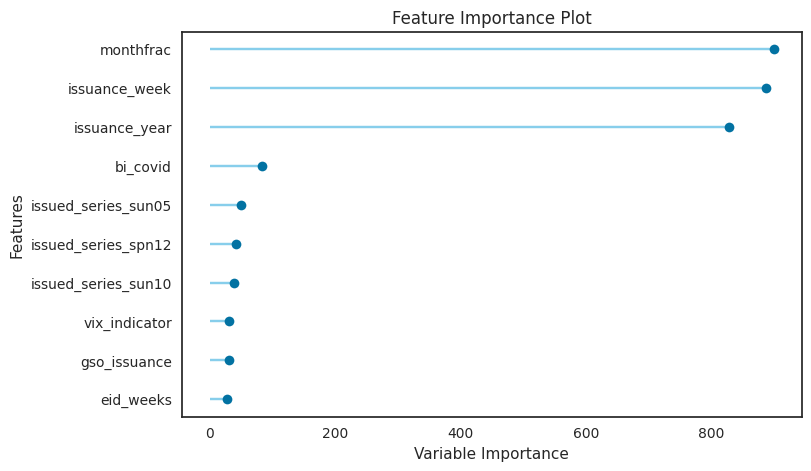

In [34]:
plot_model(create_model('lightgbm'), plot='feature')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2451864.0000,12002879602688.0000,3464517.2500,0.6404,1.4217,0.9906
1,2290705.0000,11110652575744.0000,3333264.5000,0.5816,2.1026,1.6028
2,2481329.7500,14884586651648.0000,3858054.7500,0.6874,0.6453,0.7049
3,2454650.7500,13672730591232.0000,3697665.5000,0.6244,0.6196,0.6860
4,2460127.5000,17091504635904.0000,4134187.2500,0.7052,1.2438,0.9093
5,2215778.2500,10747265417216.0000,3278302.2500,0.6970,1.3832,0.7878
6,2539664.0000,14337619001344.0000,3786504.7500,0.6302,1.3899,0.8863
7,2130940.2500,8803101704192.0000,2967002.2500,0.6166,1.5903,0.6278
8,2329088.7500,13596522184704.0000,3687346.2500,0.5998,0.6622,0.5132


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

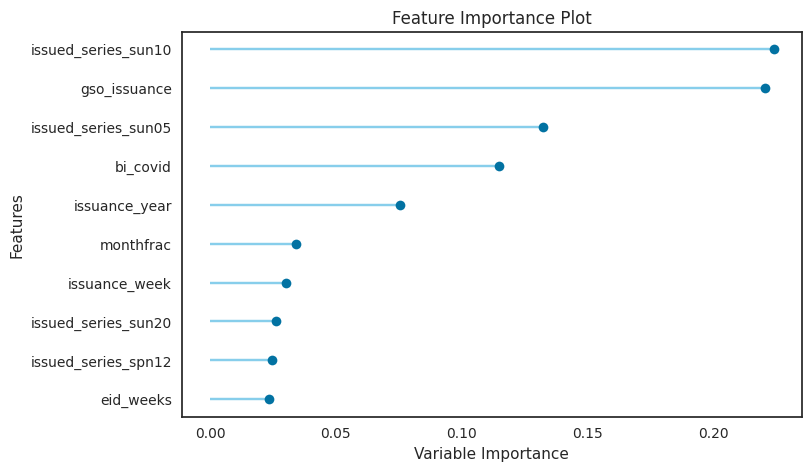

In [35]:
plot_model(create_model('xgboost'), plot='feature')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2327176.5030,11966368598041.2422,3459243.9345,0.6415,1.5382,0.8629
1,2218009.5939,10216050506599.1094,3196255.7011,0.6153,1.7663,1.1991
2,2522722.7576,17481333483907.1113,4181068.4620,0.6328,0.6138,0.6007
3,2259634.0667,10497698552771.9570,3240015.2087,0.7116,0.6888,0.5884
4,2633142.9360,18954480831642.7148,4353674.4058,0.6730,1.0402,0.6809
5,2272329.0549,12318623629694.2734,3509789.6845,0.6527,1.1046,0.7119
6,2438186.4116,13552328475008.9590,3681348.7304,0.6505,1.3075,0.8534
7,2440356.7012,12191255258189.6641,3491597.8088,0.4691,1.5826,0.5682
8,2407799.0305,13483437929564.4023,3671980.1102,0.6031,0.5535,0.5060


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

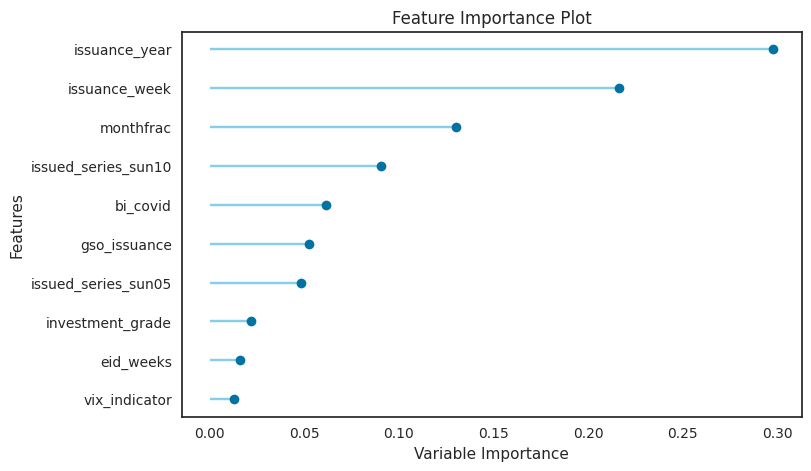

In [36]:
plot_model(create_model('et'), plot='feature')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2366791.9040,11524771273866.6621,3394815.3520,0.6548,1.6449,0.9967
1,2211627.1576,11223338882019.1445,3350125.2039,0.5774,2.1172,1.9497
2,2520746.5273,16178529847612.2148,4022254.3241,0.6602,0.6650,0.7679
3,2350859.2298,12212049684481.4512,3494574.3209,0.6645,0.6276,0.7128
4,2632449.4292,19270856805840.3281,4389858.4038,0.6676,1.2192,1.0297
5,2353183.3321,12952290968037.6211,3598929.1418,0.6348,1.2125,0.8082
6,2456246.2511,13505829680907.3613,3675027.8476,0.6517,1.3408,0.8608
7,2492691.3909,10694439952652.1426,3270235.4583,0.5343,1.6803,0.7085
8,2437365.9481,13875770652492.2500,3725019.5506,0.5915,0.5711,0.5730


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

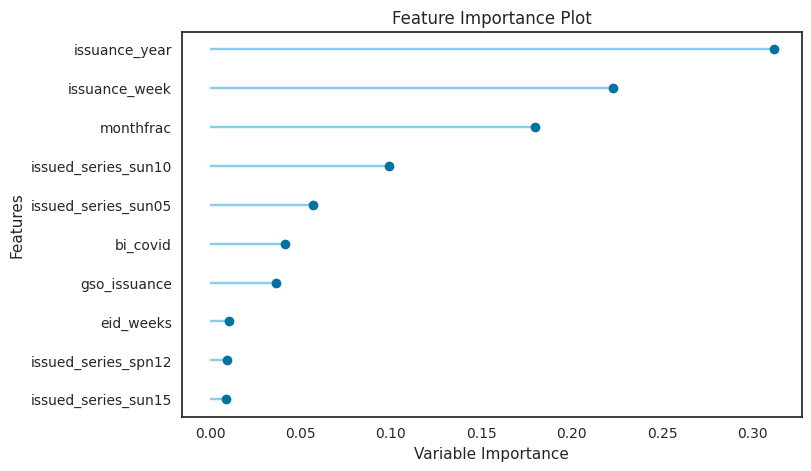

In [37]:
plot_model(create_model('rf'), plot='feature')

# Algorithms

## Light Gradient Boosting Machine

### Raw -- 63.93%

In [38]:
# train a xgb model with default params
lightgbm_raw = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2416338.6274,10708411402340.5645,3272370.9145,0.6792,1.7371,1.2321
1,2392761.1495,12347592161782.6035,3513914.0800,0.5351,2.1860,1.7082
2,2689079.6399,17931983711628.1719,4234617.3040,0.6234,0.7142,0.8790
3,2342190.5680,11408185180903.2969,3377600.5064,0.6866,0.6206,0.7083
4,2481729.1207,16614075429746.8477,4076036.7307,0.7134,1.2684,1.5133
5,2455428.0724,13434716103863.6934,3665339.8347,0.6212,1.3932,0.8896
6,2364868.9437,11565658361225.6016,3400832.0101,0.7017,1.3218,0.7737
7,2433837.6717,9759887712189.1094,3124081.8991,0.5750,1.6164,0.8139
8,2520446.3064,15717710456637.3125,3964556.7793,0.5373,0.6168,0.6415


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 57.14%

In [39]:
# tune hyperparameters of lightgbm
lightgbm_tuned = tune_model(lightgbm_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2708625.0227,13257832895051.6758,3641130.7166,0.6028,1.6326,0.9476
1,2532706.1029,12354366857611.5547,3514877.9293,0.5348,2.1552,2.4692
2,3022341.2071,20914959284417.1133,4573287.5795,0.5607,0.8660,1.0881
3,2755661.2060,15373538798827.0117,3920910.4553,0.5777,0.7523,0.8379
4,2915536.6225,20036997693248.1758,4476270.5116,0.6544,1.2807,2.5282
5,2558972.4608,14829763853248.3066,3850943.2420,0.5819,1.4175,0.9391
6,2560642.2080,13659555840539.0723,3695883.6346,0.6477,1.4423,0.8009
7,2612814.0880,12489170448685.1816,3534002.0442,0.4561,1.5950,0.8333
8,2742350.7579,17896780781801.7656,4230458.6964,0.4732,0.6885,0.6906


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Modifying -- 65.95%

In [40]:

# Define a more comprehensive tuning grid for LightGBM
lightgbm_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9, 11],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.01, 0.001],
    'reg_lambda': [1, 1.5, 2, 3, 4],
    'num_leaves': [15, 31, 63, 127],
    'min_split_gain': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample_freq': [0, 1, 2],
}

# Tune LightGBM model with custom grid and optimize for R2
lightgbm_modified = tune_model(lightgbm_raw, custom_grid=lightgbm_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2359994.8630,10178678008271.0410,3190404.0509,0.6951,1.7191,1.0769
1,2366379.6224,11320390437851.6426,3364578.7906,0.5737,2.0838,1.0293
2,2698217.1755,16582940894118.5273,4072215.7229,0.6517,0.7593,1.0138
3,2347509.9927,11633167852166.1641,3410743.0059,0.6804,0.6500,0.6718
4,2441243.8515,14905723492852.9082,3860793.1171,0.7429,1.3231,2.0809
5,2374186.4392,12058805797381.1953,3472579.1276,0.6600,1.4126,0.8915
6,2292036.4869,10882197874458.6797,3298817.6480,0.7193,1.3094,0.7972
7,2285186.8632,8645621809464.6436,2940343.8250,0.6235,1.6452,0.7077
8,2454574.9307,15519231493828.7129,3939445.5820,0.5432,0.6011,0.5794


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


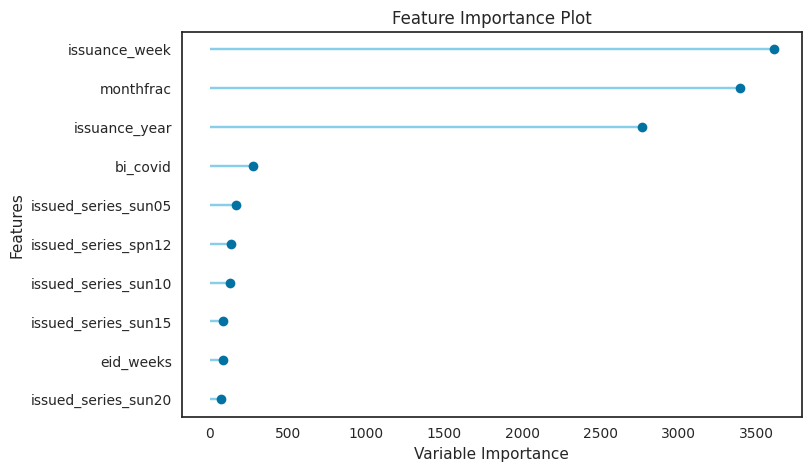

In [41]:
plot_model(lightgbm_modified, plot = 'feature')

### Bagging -- 63.14%

In [42]:
# ensemble with bagging
lightgbm_bagged = ensemble_model(lightgbm_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2375930.3540,11266560762300.6055,3356569.7911,0.6625,1.6598,1.1987
1,2421245.6268,12298990098130.3281,3506991.6022,0.5369,2.0744,1.6583
2,2711927.9520,18340338955192.6250,4282562.1951,0.6148,0.6868,0.8468
3,2287348.0385,11265548309139.4238,3356418.9710,0.6905,0.7757,0.7044
4,2619483.7728,18291665181924.3359,4276875.6332,0.6845,1.1888,1.1015
5,2439578.7550,12911347481445.4238,3593236.3520,0.6360,1.3263,0.8446
6,2407744.6172,11820174947534.7637,3438048.1305,0.6952,1.3184,0.7886
7,2499788.2613,10378857267915.5586,3221623.3901,0.5480,1.5788,0.7896
8,2549192.8848,16689875665706.2070,4085324.4260,0.5087,0.6081,0.6234


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 64.56%

In [43]:
# ensemble with boosting
lightgbm_boosted = ensemble_model(lightgbm_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2445927.2292,10432446128974.5918,3229929.7406,0.6875,1.6311,1.2983
1,2567600.7841,12662691683109.5234,3558467.6032,0.5232,2.0866,1.6310
2,2701751.5563,16393332429189.3340,4048868.0429,0.6557,0.7282,0.9592
3,2586876.5879,13220234276922.6309,3635964.0093,0.6369,0.7417,0.7990
4,2501774.2787,16573255545495.0664,4071026.3504,0.7141,1.2494,0.8576
5,2439684.9968,12371092687644.1191,3517256.4148,0.6512,1.3591,0.8548
6,2305260.7340,11099057177513.5234,3331524.7526,0.7138,1.3243,0.8190
7,2398378.3823,9567018416932.6738,3093059.7176,0.5834,1.6731,0.7723
8,2487244.4478,14543291485833.8203,3813566.7669,0.5719,0.5905,0.6162


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

## Extreme Gradient Boosting

### Raw -- 64.45%

In [44]:
# train a xgb model with default params
xgb_raw = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2451864.0000,12002879602688.0000,3464517.2500,0.6404,1.4217,0.9906
1,2290705.0000,11110652575744.0000,3333264.5000,0.5816,2.1026,1.6028
2,2481329.7500,14884586651648.0000,3858054.7500,0.6874,0.6453,0.7049
3,2454650.7500,13672730591232.0000,3697665.5000,0.6244,0.6196,0.6860
4,2460127.5000,17091504635904.0000,4134187.2500,0.7052,1.2438,0.9093
5,2215778.2500,10747265417216.0000,3278302.2500,0.6970,1.3832,0.7878
6,2539664.0000,14337619001344.0000,3786504.7500,0.6302,1.3899,0.8863
7,2130940.2500,8803101704192.0000,2967002.2500,0.6166,1.5903,0.6278
8,2329088.7500,13596522184704.0000,3687346.2500,0.5998,0.6622,0.5132


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 65.40%

In [45]:
# tune hyperparameters of xgb
xgb_tuned = tune_model(xgb_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2390805.5000,11373091225600.0000,3372401.5000,0.6593,1.5775,0.8058
1,2319704.2500,10504039825408.0000,3240993.7500,0.6045,2.1122,1.0720
2,2461188.0000,14346306453504.0000,3787651.7500,0.6987,0.7127,0.7699
3,2501515.5000,13058034368512.0000,3613590.2500,0.6413,0.6823,0.6489
4,2396656.0000,13851876655104.0000,3721811.0000,0.7611,1.3023,0.8086
5,2348001.2500,10752360448000.0000,3279079.2500,0.6969,1.3814,0.8966
6,2469848.7500,12922225950720.0000,3594749.7500,0.6667,1.3299,0.8686
7,2260437.0000,9091289186304.0000,3015176.5000,0.6041,1.5737,0.6169
8,2398494.5000,13618005409792.0000,3690258.2500,0.5991,0.7597,0.5505


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


### Modifying -- 65.41%

In [46]:
# define a more comprehensive tuning grid for XGBoost
xgb_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9, 11],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.1, 0.01, 0.001],
    'reg_lambda': [1, 1.5, 2, 3, 4]
}

# tune model with custom grid and optimize for R2
xgb_modified = tune_model(xgb_raw, custom_grid=xgb_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2393303.7500,11178437771264.0000,3343417.0000,0.6651,1.5164,0.9755
1,2178924.5000,10487393681408.0000,3238424.5000,0.6051,2.0861,1.4735
2,2577944.2500,16893157048320.0000,4110128.5000,0.6452,0.6699,0.7882
3,2240567.5000,10695114489856.0000,3270338.5000,0.7062,0.6147,0.6879
4,2542569.2500,17451050860544.0000,4177445.5000,0.6990,1.3067,1.1278
5,2204724.5000,10468108271616.0000,3235445.5000,0.7049,1.2847,0.8051
6,2392743.0000,12408204558336.0000,3522528.2500,0.6800,1.2667,0.7698
7,2317117.0000,9532216442880.0000,3087428.7500,0.5849,1.6401,0.6817
8,2415272.5000,15609684295680.0000,3950909.2500,0.5405,0.5491,0.5790


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


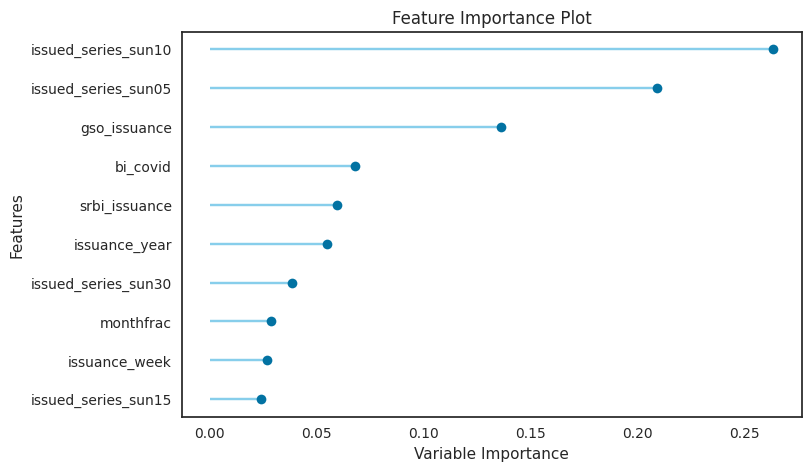

In [47]:
plot_model(xgb_modified, plot = 'feature')

### Bagging -- 65.28%

In [48]:
# ensemble with bagging
xgb_bagged = ensemble_model(xgb_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2313611.2500,11387513339904.0000,3374539.0000,0.6589,1.3375,1.0547
1,2221169.2500,10587068170240.0000,3253777.5000,0.6014,2.0533,1.6759
2,2463507.2500,15528493056000.0000,3940621.0000,0.6738,0.6216,0.6841
3,2287151.2500,11324016820224.0000,3365117.7500,0.6889,0.6120,0.6572
4,2540976.0000,18798973288448.0000,4335778.5000,0.6757,1.1648,0.7133
5,2356481.2500,11701990719488.0000,3420817.2500,0.6701,1.3306,0.8580
6,2374122.2500,12462628798464.0000,3530244.7500,0.6786,1.3216,0.8286
7,2272319.2500,8760121098240.0000,2959750.2500,0.6185,1.5929,0.6785
8,2430403.5000,15221483634688.0000,3901472.0000,0.5519,0.5597,0.5598


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 65.38%

In [49]:
# ensemble with boosting
xgb_boosted = ensemble_model(xgb_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2413675.0000,11485795319808.0000,3389070.0000,0.6559,1.6064,0.9442
1,2424706.0000,12373737865216.0000,3517632.5000,0.5341,2.0837,1.8286
2,2387258.5000,15150020034560.0000,3892302.7500,0.6818,0.6460,0.7241
3,2378381.2500,11792863461376.0000,3434074.0000,0.6761,0.6448,0.6571
4,2445778.0000,16695221551104.0000,4085978.7500,0.7120,1.1917,1.5800
5,2241658.0000,10934826303488.0000,3306785.0000,0.6917,1.3813,0.8438
6,2398277.0000,12102374785024.0000,3478846.7500,0.6879,1.2631,0.8099
7,2212697.7500,8567082450944.0000,2926958.0000,0.6269,1.4864,0.7151
8,2325251.5000,13139900891136.0000,3624900.0000,0.6132,0.5723,0.5604


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

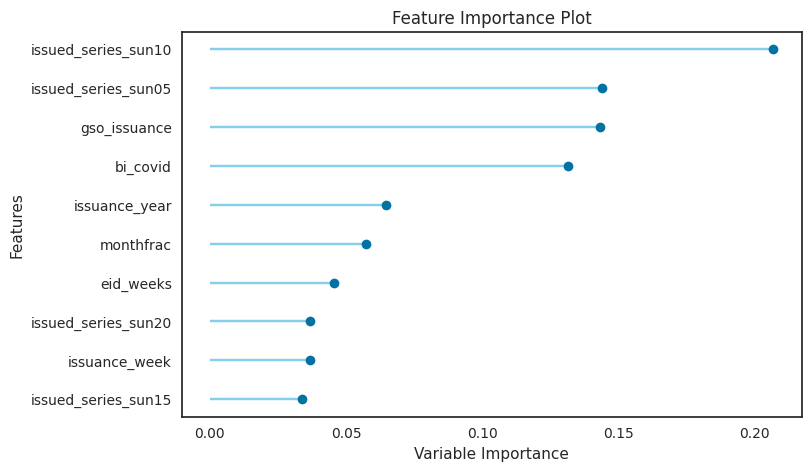

In [50]:
plot_model(xgb_boosted, plot = 'feature')

## Extra Trees Regressor

### Raw -- 63.10%

In [51]:
# train a et model with default params
et_raw = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2327176.5030,11966368598041.2422,3459243.9345,0.6415,1.5382,0.8629
1,2218009.5939,10216050506599.1094,3196255.7011,0.6153,1.7663,1.1991
2,2522722.7576,17481333483907.1113,4181068.4620,0.6328,0.6138,0.6007
3,2259634.0667,10497698552771.9570,3240015.2087,0.7116,0.6888,0.5884
4,2633142.9360,18954480831642.7148,4353674.4058,0.6730,1.0402,0.6809
5,2272329.0549,12318623629694.2734,3509789.6845,0.6527,1.1046,0.7119
6,2438186.4116,13552328475008.9590,3681348.7304,0.6505,1.3075,0.8534
7,2440356.7012,12191255258189.6641,3491597.8088,0.4691,1.5826,0.5682
8,2407799.0305,13483437929564.4023,3671980.1102,0.6031,0.5535,0.5060


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 53.47%

In [52]:
# tune hyperparameters of et
et_tuned = tune_model(et_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2807277.6500,15567132422038.7324,3945520.5515,0.5337,1.8024,1.4774
1,2596281.4371,15175948954480.0547,3895632.0353,0.4286,2.1881,2.4074
2,3033348.9779,23354952011580.4805,4832696.1431,0.5094,0.7907,1.0764
3,2604997.6778,13020593982580.2598,3608406.0169,0.6423,0.7088,0.8671
4,3092503.8149,23802620232269.2031,4878792.9073,0.5894,1.4258,4.0552
5,2626456.4811,14539288058510.9434,3813041.8380,0.5901,1.3937,1.0975
6,2979571.1012,18078515230258.3867,4251883.7273,0.5337,1.4145,0.9867
7,2719327.9188,12990241091313.8027,3604197.7042,0.4343,1.7695,0.8393
8,2797618.7126,18270973957513.0000,4274455.9838,0.4621,0.6875,0.8357


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Modifying -- 59.48%

In [53]:
# define a more comprehensive tuning grid for Random Forest Regressor
et_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 4, 8, 12],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt', None],
    'bootstrap': [True, False]
}

# Tune model with the optimized grid and optimize for Mean Squared Error (mse)
et_modified = tune_model(et_raw, custom_grid=et_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2576190.5651,13360699012862.8965,3655228.9960,0.5998,1.7316,1.4424
1,2379252.4664,12830609907428.7598,3581984.0741,0.5169,2.0334,2.1278
2,2796030.6914,19829683382346.8398,4453053.2652,0.5835,0.7476,0.9701
3,2480771.2524,12337709522447.8574,3512507.5833,0.6611,0.6476,0.7423
4,2774063.4530,21716209234907.0664,4660065.3681,0.6254,1.3107,1.6500
5,2556187.0804,13705753377633.7500,3702128.2227,0.6136,1.3369,0.9711
6,2736283.0011,15269510954318.6953,3907622.1612,0.6062,1.3441,0.9714
7,2386139.5423,10002723001227.8320,3162708.1752,0.5644,1.7248,0.7728
8,2646427.8922,17144713077615.8535,4140617.4754,0.4953,0.6599,0.7671


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Bagging -- 64.57%

In [54]:
# ensemble with bagging
et_bagged = ensemble_model(et_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2372465.2344,12893933924547.2461,3590812.4324,0.6137,1.5666,0.9901
1,2107728.0788,9333445551896.2266,3055068.8293,0.6486,1.9557,1.7338
2,2519721.4927,16976784895637.3770,4120289.4189,0.6434,0.6404,0.6883
3,2201711.0556,10435534889654.2129,3230407.8519,0.7133,0.6073,0.6473
4,2522988.9787,17992709697440.4531,4241781.4297,0.6896,1.1637,0.8737
5,2266815.7883,12039316879853.1582,3469771.8772,0.6606,1.2300,0.7796
6,2401816.6236,12640347859199.6035,3555326.6881,0.6740,1.3101,0.8469
7,2410498.6721,10556788512770.4395,3249121.1908,0.5403,1.6529,0.6437
8,2462180.5265,14293031926601.6855,3780612.6391,0.5792,0.5879,0.5731


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 63.92%

In [55]:
# ensemble with boosting
et_boosted = ensemble_model(et_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2288612.4659,11576553643315.1914,3402433.4884,0.6532,1.5858,1.0566
1,2184315.9818,9909187274530.8184,3147886.1597,0.6269,1.9538,1.7941
2,2476997.7152,16532426520776.0938,4066008.6720,0.6528,0.6166,0.6384
3,2228181.5709,9552010347982.5352,3090632.6776,0.7376,0.5954,0.6482
4,2619945.2188,18461159412176.7695,4296645.1345,0.6816,1.2163,0.8563
5,2304808.1283,12597280098496.6934,3549264.7265,0.6449,1.2549,0.7905
6,2436770.7141,13259739469702.1016,3641392.5179,0.6580,1.2953,0.8565
7,2417755.4512,11739687958899.2207,3426322.8042,0.4888,1.5701,0.6149
8,2448115.3225,13695643445227.7930,3700762.5492,0.5968,0.5804,0.5734


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

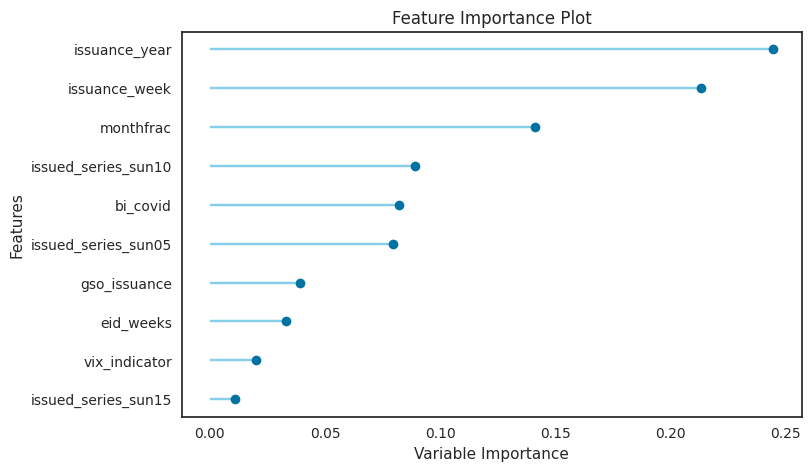

In [56]:
plot_model(et_boosted, plot = 'feature')

## Random Forest Regressor

### Raw -- 62.83%

In [57]:
# train a rf model with default params
rf_raw = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2366791.9040,11524771273866.6621,3394815.3520,0.6548,1.6449,0.9967
1,2211627.1576,11223338882019.1445,3350125.2039,0.5774,2.1172,1.9497
2,2520746.5273,16178529847612.2148,4022254.3241,0.6602,0.6650,0.7679
3,2350859.2298,12212049684481.4512,3494574.3209,0.6645,0.6276,0.7128
4,2632449.4292,19270856805840.3281,4389858.4038,0.6676,1.2192,1.0297
5,2353183.3321,12952290968037.6211,3598929.1418,0.6348,1.2125,0.8082
6,2456246.2511,13505829680907.3613,3675027.8476,0.6517,1.3408,0.8608
7,2492691.3909,10694439952652.1426,3270235.4583,0.5343,1.6803,0.7085
8,2437365.9481,13875770652492.2500,3725019.5506,0.5915,0.5711,0.5730


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 55.77%

In [58]:
# tune hyperparameters of rf
rf_tuned = tune_model(rf_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2630479.4931,13208007799972.0332,3634282.2950,0.6043,1.8038,1.4247
1,2682021.7663,14825532444862.5156,3850393.8039,0.4418,2.2191,2.9731
2,2875525.4750,21321335031126.7031,4617503.1165,0.5522,0.7627,0.9998
3,2641036.5407,15013569765747.2520,3874734.7994,0.5876,0.7071,0.8733
4,2969279.2863,22201974846524.5273,4711897.1600,0.6170,1.3701,2.8383
5,2565181.2096,14339106321249.2949,3786701.2453,0.5957,1.3917,0.9904
6,2733623.9237,15479903787381.3340,3934450.8877,0.6008,1.3962,0.8945
7,2741876.8342,12934009451524.7344,3596388.3900,0.4368,1.7979,0.8428
8,2748422.4931,17313746114530.4570,4160978.9851,0.4903,0.6503,0.7545


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Modifying -- 61.77%

In [59]:
# define a more comprehensive tuning grid for Random Forest Regressor
rf_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 4, 8, 12, 16],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Tune model with the optimized grid and optimize for Mean Squared Error (mse)
rf_modified = tune_model(rf_raw, custom_grid=rf_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2437166.9108,12070497937847.0879,3474262.2149,0.6384,1.6852,1.0660
1,2245759.7342,11693698648529.0488,3419605.0428,0.5597,2.1412,2.1603
2,2592818.0070,17273309325177.6348,4156117.0971,0.6372,0.6885,0.8263
3,2393033.7966,12656893739304.7402,3557652.8413,0.6523,0.6366,0.7329
4,2673491.6064,19841557929581.3945,4454386.3696,0.6577,1.2460,1.2417
5,2411652.7027,13527299912667.6973,3677947.7855,0.6186,1.2559,0.8519
6,2477826.2691,13482145819314.6016,3671804.1641,0.6523,1.3359,0.8388
7,2460120.8751,10501026525093.2051,3240528.7416,0.5427,1.6950,0.7199
8,2481121.6770,15031328505979.7383,3877025.7293,0.5575,0.5855,0.6075


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Bagging -- 61.52%

In [60]:
# ensemble with bagging
rf_bagged = ensemble_model(rf_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2405283.9366,11544200439545.0957,3397675.7408,0.6542,1.6851,1.1686
1,2319650.7881,11486676454555.1602,3389199.9726,0.5675,2.1344,2.6655
2,2758918.0945,18169894669835.1250,4262615.9421,0.6184,0.7194,0.9020
3,2440342.7360,12987289242683.4219,3603788.1795,0.6433,0.6752,0.8143
4,2811304.2338,21308856817594.1328,4616151.7325,0.6324,1.2962,1.5923
5,2469249.9529,12993007343384.3750,3604581.4380,0.6337,1.3276,0.9162
6,2561862.1374,13872364715407.3164,3724562.3522,0.6422,1.3666,0.8836
7,2501763.5284,10471540750361.3945,3235976.0120,0.5440,1.7148,0.7719
8,2624282.4492,16077051203205.8633,4009619.8328,0.5267,0.6156,0.6732


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 63.88%

In [61]:
# ensemble with boosting
rf_boosted = ensemble_model(rf_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2384572.5676,10997311276156.1172,3316219.4252,0.6706,1.7191,1.2626
1,2290122.5394,12290460833969.1816,3505775.3542,0.5372,2.1218,1.7452
2,2513095.4182,16491587137652.2168,4060983.5185,0.6536,0.7258,0.9161
3,2395609.5446,11413294741789.0684,3378356.8109,0.6865,0.6654,0.8030
4,2612960.1499,19257405494903.6211,4388326.0470,0.6678,1.3004,1.6357
5,2368360.0104,11795974952094.1133,3434526.8891,0.6674,1.2937,0.9194
6,2484798.8981,13410379840910.7168,3662018.5473,0.6541,1.3457,0.9515
7,2440091.8270,10167498737578.6855,3188651.5547,0.5572,1.6883,0.7617
8,2404502.6044,12568707336808.4961,3545237.2751,0.6300,0.5888,0.6394


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

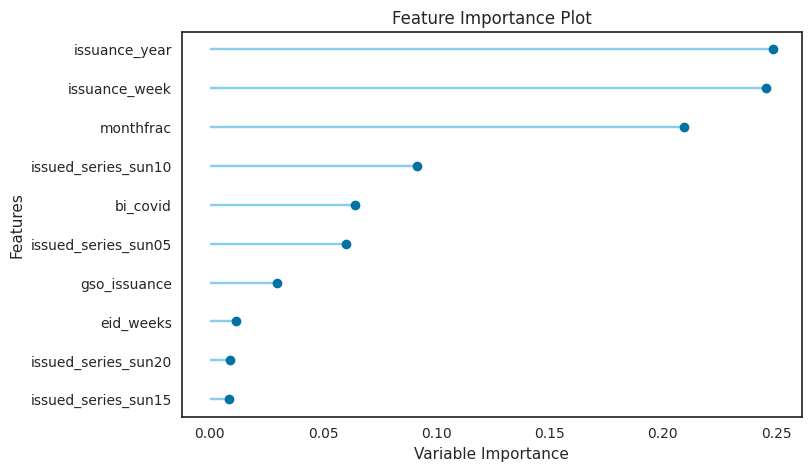

In [62]:
plot_model(rf_boosted, plot = 'feature')

# Choosen

## Blended -- 67.74%

In [63]:
# Blend the Boosted Ensembles
blended = blend_models(estimator_list=[lightgbm_modified, xgb_modified, et_bagged, rf_boosted], fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2284518.2501,10484166344815.1855,3237926.2414,0.6859,1.4172,0.8814
1,2099934.5315,9750388818437.6484,3122561.2594,0.6329,1.9862,1.4257
2,2444052.9920,15727463617033.2676,3965786.6328,0.6697,0.7040,0.7781
3,2194387.6677,10170390507782.4844,3189104.9697,0.7206,0.6074,0.6728
4,2426334.1088,16478202171129.3535,4059335.1883,0.7158,1.1835,0.6213
5,2225890.8368,10871082154825.2812,3297132.4139,0.6935,1.2976,0.8190
6,2287247.3352,11449725264684.4941,3383744.2670,0.7047,1.2955,0.8079
7,2258017.3324,8840062348298.9727,2973224.2344,0.6150,1.6183,0.6693
8,2350595.3576,13569994151256.3926,3683747.2974,0.6005,0.5507,0.5455


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [64]:
predict_model(blended);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,2209778.6109,9534001233624.6504,3087717.8034,0.6774,0.6235,0.6988


In [ ]:
# plot_model(blended, plot = 'residuals')

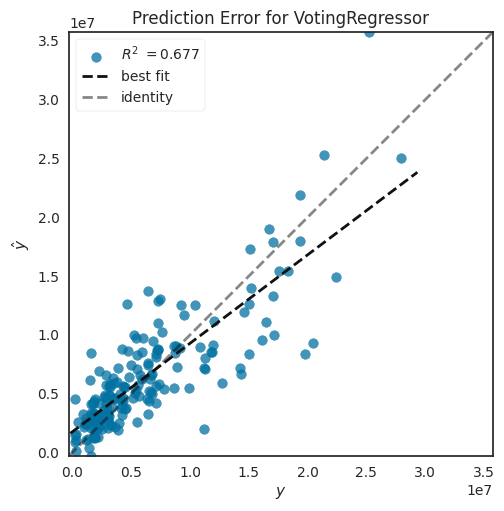

In [65]:
plot_model(blended, plot = 'error')

## Stacked -- 67.43%

In [66]:
stacked = stack_models(estimator_list=[lightgbm_modified, xgb_modified, et_bagged, rf_boosted])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2277505.3135,10754396228477.4316,3279389.6122,0.6778,1.5623,0.8607
1,2097467.7227,9581980002972.2051,3095477.3465,0.6392,2.0252,1.2825
2,2433862.7643,15632464681452.4727,3953791.1783,0.6717,0.6747,0.7748
3,2157241.6884,10138073375349.0156,3184034.1354,0.7215,0.5916,0.6222
4,2397930.7381,16486564457193.1523,4060365.0645,0.7156,1.1224,0.7459
5,2228652.6416,11124289272834.0859,3335309.4718,0.6864,1.3112,0.8010
6,2266604.1725,11317535495973.4609,3364154.4994,0.7081,1.2905,0.7667
7,2237895.5103,8854447477461.4785,2975642.3638,0.6144,1.5779,0.6494
8,2363539.5478,14165104610914.0859,3763655.7509,0.5830,0.6276,0.5302


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [67]:
predict_model(stacked);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,2226704.2455,9728519920011.2109,3119057.5371,0.6709,0.6015,0.6352


In [ ]:
# plot_model(stacked, plot = 'residuals')

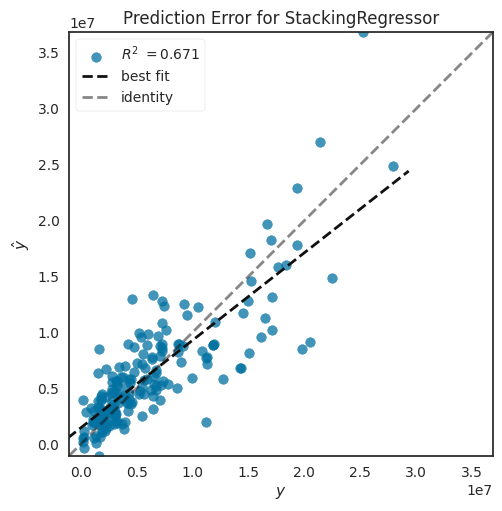

In [68]:
plot_model(stacked, plot = 'error')

## Finalizing -- 92.39%

In [69]:
final = finalize_model(blended)
predict_model(final);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,1109590.3413,2250790290950.8960,1500263.4072,0.9239,0.3638,0.3195


In [70]:
save_model(final, '/content/drive/MyDrive/00database/20240226_blended01')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['issuance_year', 'issuance_week',
                                              'monthfrac', 'eid_weeks',
                                              'srbi_issuance', 'vix_indicator',
                                              'bi_covid', 'gso_issuance',
                                              'investment_grade'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['issued_series'],
                                     transformer=SimpleImpute...
                                                            multi_strategy=None,
                                                            n_estimators=50,
                                                            n_jobs=-1,
                                                            num_parallel_tree=Non

# Lelang 26 Feb 2024

## Load

In [71]:
lelang20240227 = pd.read_excel('/content/drive/MyDrive/00database/db_monthfrac.xlsx', sheet_name='lelang20240227')
lelang20240227['issuance_date'] = pd.to_datetime(lelang20240227['issuance_date'], format='%d/%m/%Y')
lelang20240227.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   issued_series     7 non-null      object        
 1   issuance_date     7 non-null      datetime64[ns]
 2   issuance_year     7 non-null      int64         
 3   issuance_week     7 non-null      int64         
 4   monthfrac         7 non-null      int64         
 5   eid_weeks         7 non-null      int64         
 6   srbi_issuance     7 non-null      int64         
 7   vix_indicator     7 non-null      int64         
 8   bi_covid          7 non-null      int64         
 9   gso_issuance      7 non-null      int64         
 10  investment_grade  7 non-null      int64         
dtypes: datetime64[ns](1), int64(9), object(1)
memory usage: 744.0+ bytes


## Predict

In [72]:
# load model
blended01_20240226 = load_model("/content/drive/MyDrive/00database/20240226_blended01")

# predict model on new_data
predict03= predict_model(blended01_20240226, data = lelang20240227)
predict03

# predict model on new_data
# predict03= predict_model(final, data = lelang20240130)
# predict03

Transformation Pipeline and Model Successfully Loaded


,issued_series,issuance_date,issuance_year,issuance_week,monthfrac,eid_weeks,srbi_issuance,vix_indicator,bi_covid,gso_issuance,investment_grade,prediction_label
0,spn03,2024-02-27,2024,9,3,0,1,0,0,0,1,1.939937e+06
1,spn12,2024-02-27,2024,9,12,0,1,0,0,0,1,8.460086e+06
2,sun05,2024-02-27,2024,9,62,0,1,0,0,0,1,1.806418e+07
3,sun10,2024-02-27,2024,9,120,0,1,0,0,0,1,1.509059e+07
4,sun15,2024-02-27,2024,9,172,0,1,0,0,0,1,6.004578e+06
5,sun20,2024-02-27,2024,9,232,0,1,0,0,0,1,3.775209e+06
6,sun30,2024-02-27,2024,9,365,0,1,0,0,0,1,4.667115e+06


In [73]:
# @title Lelang 20240227: Per series

# !pip install --upgrade pip
# !pip install tabulate

import tabulate

# Incoming bid per series
predict04 = predict03[['issued_series', 'issuance_date', 'prediction_label']]

# Create a new column with formatted dates
predict04['issuance_date'] = predict04['issuance_date'].dt.strftime('%Y-%m-%d')

# Format the 'prediction_label' column
predict04['prediction_label'] = predict04['prediction_label'].apply(lambda x: '{:,.2f} trillion'.format(x / 1_000_000))

# Convert the DataFrame to a list of dictionaries for tabulate
table_data = predict04.to_dict(orient='records')

# Specify the column alignments
column_alignments = {'issued_series': 'left', 'issuance_date': 'center', 'prediction_label': 'right'}

# Display the formatted DataFrame using tabulate
formatted_table = tabulate.tabulate(table_data, headers="keys", floatfmt=".2f", showindex=False, colalign=list(column_alignments.values()), tablefmt="pipe")

print(formatted_table)

| issued_series   |  issuance_date  |   prediction_label |
|:----------------|:---------------:|-------------------:|
| spn03           |   2024-02-27    |      1.94 trillion |
| spn12           |   2024-02-27    |      8.46 trillion |
| sun05           |   2024-02-27    |     18.06 trillion |
| sun10           |   2024-02-27    |     15.09 trillion |
| sun15           |   2024-02-27    |      6.00 trillion |
| sun20           |   2024-02-27    |      3.78 trillion |
| sun30           |   2024-02-27    |      4.67 trillion |


In [75]:
# @title Lelang 20240227: Total

# Sum total incoming bid
incoming_bid = predict03['prediction_label'].sum()

# Round to two decimal places
rounded_bid = round(incoming_bid, 2)
formatted_rounded_bid = 'Rp{:,.2f} million'.format(rounded_bid)

# Adjust to the nearest thousand
formatted_incoming_bid = 'Rp{:,.2f} trillion'.format(rounded_bid / 1000000)

output_message = f"""
According to a blended machine learning algorithm model with an R-squared value of 67.74%,
the estimated incoming bid for the next issuance is approximately {formatted_rounded_bid}
or {formatted_incoming_bid}.
"""

print(output_message)



According to a blended machine learning algorithm model with an R-squared value of 67.74%,
the estimated incoming bid for the next issuance is approximately Rp58,001,690.61 million
or Rp58.00 trillion.

